In [197]:
import numpy as np
from numpy.linalg import norm
import time
import matplotlib.pyplot as plt
import scipy
from scipy import sparse
from pathlib import Path
from scipy import io
import random
import copy

**ZO Frank-Wolfe**

In [198]:
def propagate_labels(A,d,theta,Y,max_iter=15):   #Label propagation algorithm
    l=theta[-1]   
    d_array=np.squeeze(np.asarray(d))
    d_array=np.nan_to_num(d_array,posinf=1e300,neginf=-1e300)   #Make sure to avoid nan or infs
    z=np.reciprocal(1+l*d_array)
    z=np.nan_to_num(z,posinf=1e300,neginf=-1e300)
    Z=sparse.diags(z)
    X0=Z @ Y
    X=copy.deepcopy(X0)
    for i in range(max_iter):
        X=l*(A @ Z @ X) + X0
    return X

In [199]:
def H(X,Y):    #Cross-entropy
    N=Y.shape[0]
    #Normalize rows of X
    row_sums=X.sum(axis=1)
    r=np.squeeze(np.asarray(row_sums))
    r[r==0]=1
    r=np.reciprocal(r)
    r=np.nan_to_num(r,posinf=1e300,neginf=-1e300)   #To avoid overflow issues
    R=sparse.diags(r)
    X_norm= R @ X
    #Apply logarithm
    X_to_log=X_norm.toarray()
    X_to_log[X_to_log==0]=1e-300  #Avoid taking log of 0
    Y_calc=Y.toarray()
    Xlog=np.log(X_to_log)
    return (-1/N)*np.sum(np.multiply(Xlog,Y_calc))  #Sum

In [200]:
def get_matrices(A_list,theta):   # Generalized mean of adjacency matrices
    alpha=theta[0]
    A_list_power=[theta[i+1]*(A_list[i].power(alpha)) for i in range(len(A_list))]
    A=sum(A_list_power)
    A.eliminate_zeros()
    A=A.power(1/alpha)
    A.data=np.nan_to_num(A.data,posinf=1e300,neginf=-1e300)
    return A,A.sum(axis=1)

In [201]:
def f(A_list,Ytr,Yte,theta):   # Obj function
    A,d=get_matrices(A_list,theta)
    X=propagate_labels(A,d,theta,Ytr)
    return H(X,Yte)

In [202]:
def gradient_estimate(A_list,Ytr,Yte,theta,f0,h):   #Estimate of the gradient
    n=len(theta)
    vectors=np.eye(n)
    return np.asarray([(f(A_list,Ytr,Yte,theta+h*vector)-f0)/h for vector in vectors])

In [211]:
def ZOFW(A_list,Ytr,Yte,theta0,h0=1e-4,l0=0.1,l1=10,a=20,max_iter=1000,tol=1e-4,delta=0.75,gamma=0.1):

    start=time.time()
    h=h0
    theta=np.asarray(theta0)    #We store the parameters as theta=(alpha,beta,lambda)
    loss_history=[]
    gap_history=[]
    times=[0]
    K=len(theta)
    f0=f(A_list,Ytr,Yte,theta)
    loss_history.append(f0)

    for i in range(max_iter):   #Main loop
        grad=gradient_estimate(A_list,Ytr,Yte,theta,f0,h)
        theta_bar=np.zeros(K)   #Find theta_bar
        if grad[0]<0:
            theta_bar[0]=a
        else:
            theta_bar[0]=-a
        if grad[-1]<0:
            theta_bar[-1]=l1
        else:
            theta_bar[-1]=l0
        theta_bar[np.argmin(grad[1:-1])+1]=1
        d_t=theta_bar-theta

        #Stop condition
        G=-np.dot(grad,d_t)
        if G < tol:
            break


        #Armijo line search
        nu=1
        threshold=gamma*G
        theta_new=theta+d_t
        f_new=f(A_list,Ytr,Yte,theta_new)
        gap=f0-f_new
        while gap < threshold and nu>=h*1e-5:  #Second condition in case line search gets stuck
            nu *= delta
            threshold *= delta
            theta_new=theta+nu*d_t
            f_new=f(A_list,Ytr,Yte,theta_new)
            gap=f0-f_new
        
        #Update
        theta=theta_new
        f0=f_new
        h=h/2
        times.append(time.time()-start)
        loss_history.append(f0)
        gap_history.append(G)
        
    
    gap_history.append(G)
    return theta,loss_history,times,gap_history


In [204]:
def array_in_list(a,L):   #Check if array is in list of arrays
    for a_bar in L:
        if np.array_equal(a,a_bar):
            return True
    return False

In [215]:
def AS_ZOFW(A_list,Ytr,Yte,theta0,h0=1e-4,l0=0.1,l1=10,a=20,max_iter=1000,tol=1e-4,delta=0.75,gamma=0.1):

    start=time.time()
    h=h0
    theta=np.asarray(theta0)
    loss_history=[]
    times=[0]
    gap_history=[]
    K=len(theta)
    f0=f(A_list,Ytr,Yte,theta)
    loss_history.append(f0)
    S=[theta]         #List of active atoms
    coeffs=np.asarray([1])  #Tracks writing of theta as convex combination of active atoms

    for i in range(max_iter):
        grad=gradient_estimate(A_list,Ytr,Yte,theta,f0,h)
        theta_bar=np.zeros(K)   #Find theta_bar
        if grad[0]<0:
            theta_bar[0]=a
        else:
            theta_bar[0]=-a
        if grad[-1]<0:
            theta_bar[-1]=l1
        else:
            theta_bar[-1]=l0
        theta_bar[np.argmin(grad[1:-1])+1]=1
        dir_FW=theta_bar-theta

        #Stop condition
        G_FW=-np.dot(grad,dir_FW)
        if G_FW < tol:
            break

        v_t=S[0]       #Find dir_AS
        ev_max=np.dot(grad,v_t)
        for atom in S[1:]:
            ev=np.dot(grad,atom)
            if ev > ev_max:
                v_t=atom
                ev_max=ev
        dir_AS=theta-v_t

        G_AS=-np.dot(grad,dir_AS)   #Check whether to do FW step or AS
        if G_FW >= G_AS or len(S)==1:
            d_t=dir_FW
            max_step=1
            flag=0
        else:
            flag=1
            d_t=dir_AS
            for atom,coeff in zip(S,coeffs):
                if np.array_equal(atom,v_t):
                    max_step=coeff/(1-coeff)
                    break


        #Armijo line search
        nu=max_step
        threshold=gamma*nu*G_FW
        theta_new=theta+nu*d_t
        f_new=f(A_list,Ytr,Yte,theta_new)
        gap=f0-f_new
        while gap < threshold and nu >= h*1e-6:
            nu *= delta
            threshold *= delta
            theta_new=theta+nu*d_t
            f_new=f(A_list,Ytr,Yte,theta_new)
            gap=f0-f_new

        #Update decomposition as convex combination
        if flag==0:            #In case of FW step
            coeffs=coeffs*(1-nu)
            if not array_in_list(theta_bar,S):
                S.append(theta_bar)
                coeffs=np.append(coeffs,nu)
            else:
                for i in range(len(S)):
                    if np.array_equal(theta_bar,S[i]):
                        coeffs[i]+=nu
                        break
                        
            if nu==max_step:   #Check if we went all the way to atom
                S=[theta_bar]
                coeffs=np.asarray([1])

        if flag==1:   #In case of AS
            coeffs=coeffs*(1+nu)
            for i in range(len(S)):
                if np.array_equal(v_t,S[i]):
                    coeffs[i]-=nu
                    if nu==max_step:   #Check if v_t is no longer active atom
                        del S[i]
                        coeffs=np.delete(coeffs,i)
                    break

        theta=theta_new
        f0=f_new
        h=h/2
        times.append(time.time()-start)
        loss_history.append(f0)
        gap_history.append(G_FW)
        
    gap_history.append(G_FW)
    return theta,loss_history,times,gap_history,acc


**Accuracy testing**

In [216]:
def test_FW(dataset,as_flag):
    A_list=dataset['A_list'][0]
    Y_list=dataset['Y_list'][0]
    Y=Y_list[0]
    Y[Y>0]=1
    #Create matrix with labels for all the nodes
    labels_array=dataset['labels_list'][0]
    labels=np.zeros(Y.shape)
    for i in range(labels_array.shape[0]):
        labels[i][int(labels_array[i])]=1
    #Split Y into 5 parts
    Yte_list=[] #List of test sets
    available_inputs=np.squeeze(np.asarray(Y.sum(axis=1)))
    perc=Y.sum()/5
    Y_var=copy.deepcopy(Y)
    for i in range(4):
        inputs=np.zeros(Y.shape[0])
        #Get 20% of available inputs
        while np.sum(inputs)<perc:
            index=np.random.randint(Y.shape[0])
            inputs[index]=available_inputs[index]
        #Create a test matrix with them
        I=sparse.diags(inputs)
        Yte=I @ Y
        Yte.eliminate_zeros()
        Yte_list.append(Yte)
        #Reduce available inputs by those put in the test matrix
        Y_var -= Yte
        available_inputs=np.squeeze(np.asarray(Y_var.sum(axis=1)))
    Y_var.eliminate_zeros()
    Yte_list.append(Y_var)
    #Then run multistart FW for each test set, selecting best total outcome
    #Create list of starting points
    theta_list=[]
    if as_flag==0: #If we're testing ZOFW
        theta0_1=np.zeros(len(A_list)+2)
        theta0_2=np.zeros(len(A_list)+2)
        theta0_3=np.zeros(len(A_list)+2)
        #Arithmetic mean
        theta0_1[0]=1
        theta0_1[-1]=1
        theta0_1[1:-1]=1/len(A_list)
        #Harmonic mean
        theta0_2[0]=-1
        theta0_2[-1]=1
        theta0_2[1:-1]=1/len(A_list)
        #Random theta
        theta0_3[0]=random.uniform(-20,20)
        theta0_3[-1]=random.uniform(0.1,10)
        theta0_3[1:-1]=np.random.rand(len(theta0_3)-2).tolist()
        theta0_3[1:-1] /= sum(theta0_3[1:-1])
        #print(theta0_3)
        theta_list=[theta0_1,theta0_2,theta0_3]
    else:   #If we're testing AS_FOFW
        theta0_1=np.zeros(len(A_list)+2)
        theta0_2=np.zeros(len(A_list)+2)
        theta0_3=np.zeros(len(A_list)+2)
        
        theta0_1[0]=20
        theta0_1[-1]=10
        theta0_1[1]=1
        
        theta0_2[0]=-20
        theta0_2[-1]=0.1
        theta0_2[-2]=1
        
        #Random theta
        theta0_3[0]=20
        theta0_3[-1]=0.1
        theta0_3[random.randint(1,len(A_list))]=1
        theta_list=[theta0_1,theta0_2,theta0_3]
    best_f=1e100
    #Find best theta
    for Yte in Yte_list:
        Ytr=Y-Yte
        Ytr.eliminate_zeros()
        for theta0 in theta_list:
            if as_flag==0:
                out=ZOFW(A_list,Ytr,Yte,theta0)
            else:
                out=AS_ZOFW(A_list,Ytr,Yte,theta0)
            if out[1][-1] < best_f:  #Final f 
                best_f=out[1][-1]   
                best_theta=out[0]
            print('Done')
    #Rerun label propagation with all input labels, and get accuracy
    A,d=get_matrices(A_list,best_theta)
    X=propagate_labels(A,d,best_theta,Y)
    Xlabels=X.toarray()
    Xlabels=(Xlabels >= np.sort(Xlabels, axis=1)[:,[-1]]).astype(int)
    acc=np.sum(np.multiply(Xlabels,labels-Y.toarray()))/np.sum(labels-Y.toarray())
    return acc,best_theta

In [217]:
folder=Path("data")   #Loading datasets
BBC_datasets={}
for input_percent in [1,5,10,15]:
    for noise in [0,1,2]:
        BBC_datasets["{}_{}".format(input_percent,noise)]=io.loadmat(folder / "BBC_{}_{}.mat".format(input_percent,noise))
        
dkpol_datasets={}
for input_percent in [1,5,10,15]:
    for noise in [0,1,2]:
        dkpol_datasets["{}_{}".format(input_percent,noise)]=io.loadmat(folder / "dkpol_{}_{}.mat".format(input_percent,noise))
        
cora_datasets={}
for input_percent in [1,5,10,15]:
    for noise in [0,1,2]:
        cora_datasets["{}_{}".format(input_percent,noise)]=io.loadmat(folder / "cora_{}_{}.mat".format(input_percent,noise))

In [218]:
results_BBC=[]
for input_percent in [1,5,10,15]:
    for noise in [0,1,2]:
        results_BBC.append(test_FW(BBC_datasets["{}_{}".format(input_percent,noise)],0))
        print('Dataset done')

KeyboardInterrupt: 

In [ ]:
print([result[0] for result in results_BBC])
for result in results_BBC:
    print(result[1])

In [131]:
AS_results_BBC=[]
for input_percent in [1,5,10,15]:
    for noise in [0,1,2]:
        AS_results_BBC.append(test_FW(BBC_datasets["{}_{}".format(input_percent,noise)],1))
        print('Dataset done')

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


<ipython-input-112-9e8bda2648b7>:7: RuntimeWarning: overflow encountered in reciprocal
  r=np.reciprocal(r)
<ipython-input-112-9e8bda2648b7>:15: RuntimeWarning: invalid value encountered in multiply
  return (-1/N)*np.sum(np.multiply(Xlog,Y_calc))


Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done


In [137]:
print([result[0] for result in AS_results_BBC])
for result in AS_results_BBC:
    print(result[1])

[0.6607407407407407, 0.6607407407407407, 0.7674074074074074, 0.7784615384615384, 0.7584615384615384, 0.7784615384615384, 0.7957860615883307, 0.7957860615883307, 0.766612641815235, 0.8164665523156089, 0.8164665523156089, 0.8164665523156089]
[-20.    1.    0.    0.    0.    0.1]
[20.   1.   0.   0.   0.   0.   0.1]
[1.99698983e+01 9.99247457e-01 7.52543458e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.07450180e-01]
[-20.    0.    0.    0.    1.    0.1]
[-20.    1.    0.    0.    0.    0.    0.1]
[-20.    0.    0.    0.    1.    0.    0.    0.1]
[-20.    1.    0.    0.    0.    0.1]
[-20.    1.    0.    0.    0.    0.    0.1]
[-20.    0.    1.    0.    0.    0.    0.    0.1]
[-20.    1.    0.    0.    0.    0.1]
[-20.    1.    0.    0.    0.    0.    0.1]
[-20.    1.    0.    0.    0.    0.    0.    0.1]


In [152]:
results_cora=[]
for input_percent in [1,5,10,15]:
    for noise in [0,1,2]:
        results_cora.append(test_FW(cora_datasets["{}_{}".format(input_percent,noise)],0))
        print('Dataset done')
print([result[0] for result in results_cora])
for result in results_cora:
    print(result[1])

Done
Done
Done
Done
Done
Done


<ipython-input-143-f2ce072b5b9f>:7: RuntimeWarning: overflow encountered in reciprocal
  r=np.reciprocal(r)


Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done


<ipython-input-142-c0eccf4ffbb7>:4: RuntimeWarning: overflow encountered in multiply
  z=np.reciprocal(1+l*d_array)


Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
[0.69041402461768, 0.5382320029839612, 0.5236851920925027, 0.7593312597200622, 0.7072317262830482, 0.7328926905132193, 0.7623

In [153]:
AS_results_cora=[]
for input_percent in [1,5,10,15]:
    for noise in [0,1,2]:
        AS_results_cora.append(test_FW(cora_datasets["{}_{}".format(input_percent,noise)],1))
        print('Dataset done')
print([result[0] for result in AS_results_cora])
for result in AS_results_cora:
    print(result[1])

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done


<ipython-input-143-f2ce072b5b9f>:7: RuntimeWarning: overflow encountered in reciprocal
  r=np.reciprocal(r)


Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done


<ipython-input-142-c0eccf4ffbb7>:4: RuntimeWarning: overflow encountered in multiply
  z=np.reciprocal(1+l*d_array)


Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Done
Dataset done
[0.6113390525923162, 0.6154419992540097, 0.7314434912346139, 0.7212286158631416, 0.6881804043545878, 0.7468895800933126, 0.7422003284072249, 0.7725779967159278, 0.7553366174055829, 0.7882608695652173, 0.8052173913043478, 0.7921739130434783]
[2.00000000e+01 1.00000000e+00 4.75141054e-14 1.00000000e-01]
[2.00000000e+01 1.00000

**Comparisons between FW and AS_FW**

In [221]:
def compare_FW(dataset):
    A_list=dataset['A_list'][0]
    Y_list=dataset['Y_list'][0]
    Y=Y_list[0]
    Y[Y>0]=1
    #Split training and test
    available_inputs=np.squeeze(np.asarray(Y.sum(axis=1)))
    perc=Y.sum()/5
    inputs=np.zeros(Y.shape[0])
    #Get 20% of available inputs
    while np.sum(inputs)<perc:
        index=np.random.randint(Y.shape[0])
        inputs[index]=available_inputs[index]
    #Create a test matrix with them
    I=sparse.diags(inputs)
    Yte=I @ Y
    Yte.eliminate_zeros()
    #Reduce available inputs by those put in the test matrix
    Ytr =Y-Yte

    #Random theta
    theta0[0]=20
    theta0[-1]=0.1
    theta0[random.randint(1,len(A_list))]=1
    
    
    out_FW=ZOFW(A_list,Ytr,Yte,theta0)
    out_AS=AS_ZOFW(A_list,Ytr,Yte,theta0) 
    
    times_fig,times_ax=plt.subplots()
    loss_fig1,loss_ax1=plt.subplots()
    loss_fig2,loss_ax2=plt.subplots()
    gap_fig1,gap_ax1=plt.subplots()
    gap_fig2,gap_ax2=plt.subplots()
    
    times_ax.plot(out_FW[2],label='ZOFW')
    times_ax.plot(out_AS[2],label='AS ZOFW')
    times_ax.set_title('Time over iterations')
    times_ax.set_xlabel('Iteration')
    times_ax.set_ylabel('Time (s)')
    times_ax.legend()
    
    loss_ax1.plot(out_FW[2],out_FW[1],label='ZOFW')
    loss_ax1.plot(out_AS[2],out_AS[1],label='AS_ZOFW')
    loss_ax2.plot(out_FW[1],label='ZOFW')
    loss_ax2.plot(out_AS[1],label='AS_ZOFW')
    loss_ax1.set_title('f over time')
    loss_ax1.set_xlabel('Time(s)')
    loss_ax1.set_ylabel('f')
    loss_ax1.set_yscale('log')
    loss_ax2.set_title('f over iterations')
    loss_ax2.set_xlabel('Iteration')
    loss_ax2.set_ylabel('f')
    loss_ax2.set_yscale('log')
    loss_ax1.legend()
    loss_ax2.legend()
    
    gap_ax1.plot(out_FW[2],out_FW[3],label='ZOFW')
    gap_ax1.plot(out_AS[2],out_AS[3],label='AS_ZOFW')
    gap_ax2.plot(out_FW[3],label='ZOFW')
    gap_ax2.plot(out_AS[3],label='AS_ZOFW')
    gap_ax1.set_title('FW gap over time')
    gap_ax1.set_yscale('log')
    gap_ax1.set_xlabel('Time(s)')
    gap_ax1.set_ylabel('gap')
    gap_ax2.set_title('FW gap over iterations')
    gap_ax2.set_xlabel('Iteration')
    gap_ax2.set_ylabel('gap')
    gap_ax2.set_yscale('log')
    gap_ax1.legend()
    gap_ax2.legend()
    
    plt.show()
    return out_FW[2][-1],out_AS[2][-1]


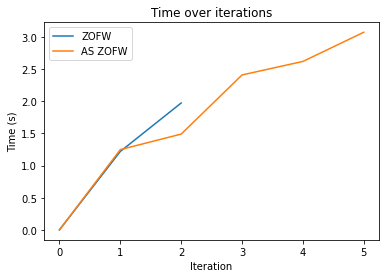

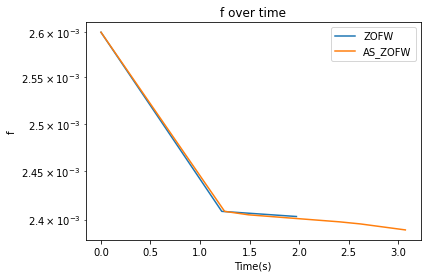

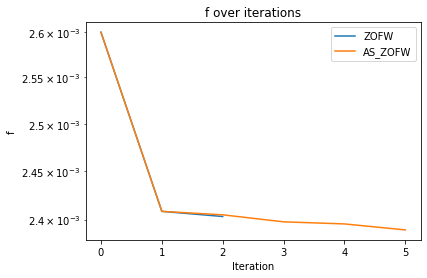

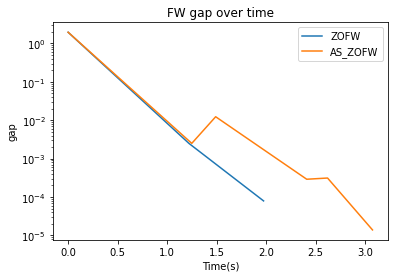

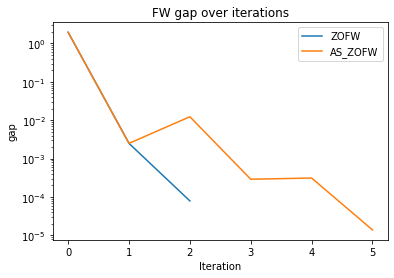

<ipython-input-221-71081c8e2b63>:103: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  gap_ax1.set_yscale('log')
<ipython-input-221-71081c8e2b63>:109: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  gap_ax2.set_yscale('log')


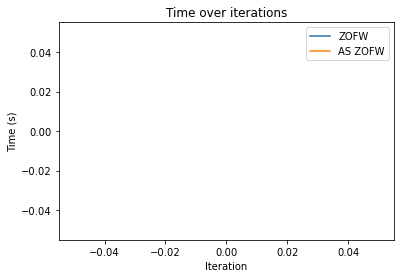

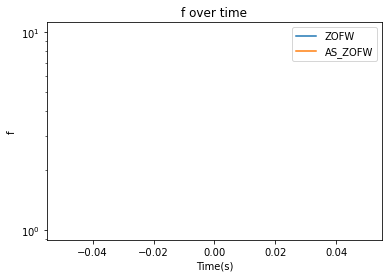

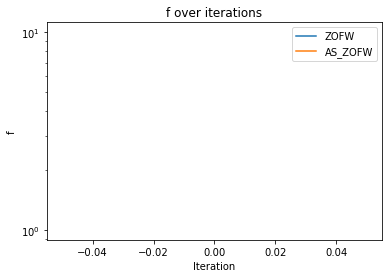

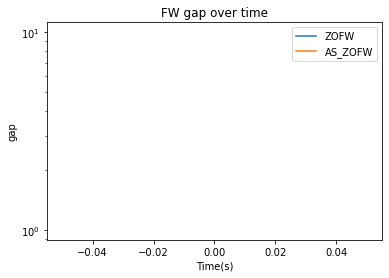

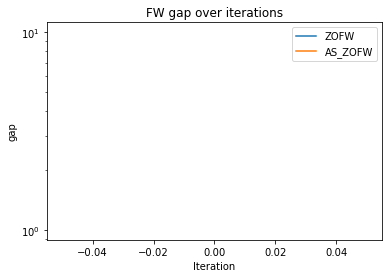

Dataset done


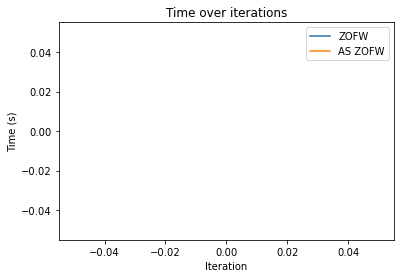

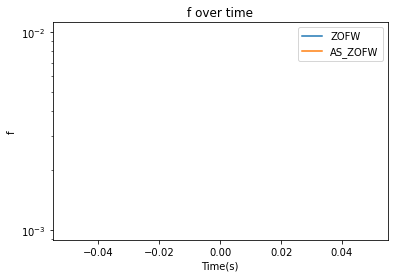

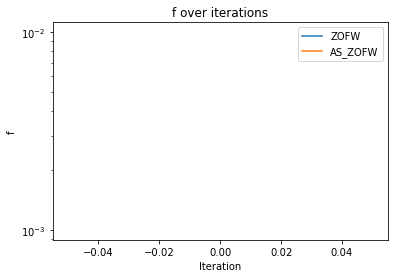

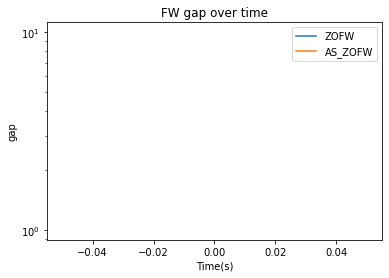

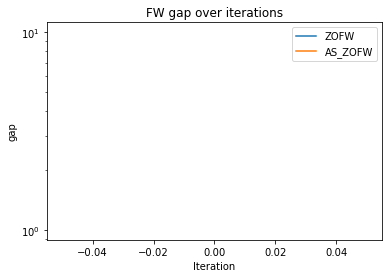

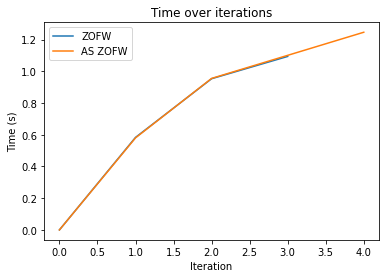

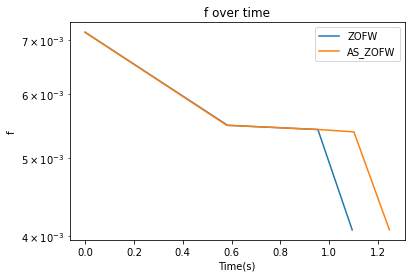

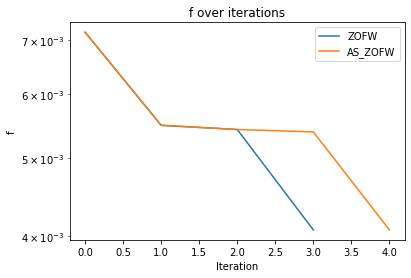

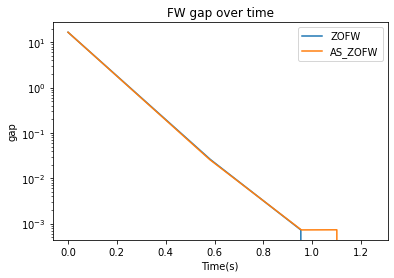

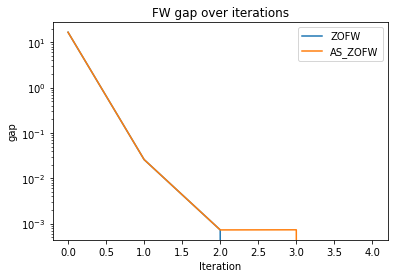

Dataset done


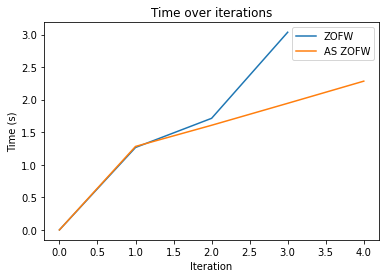

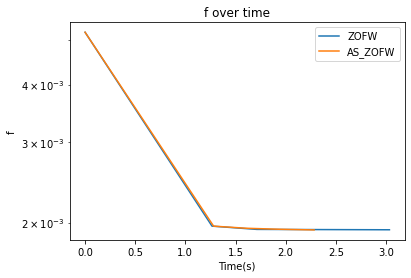

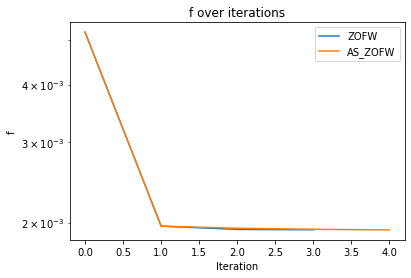

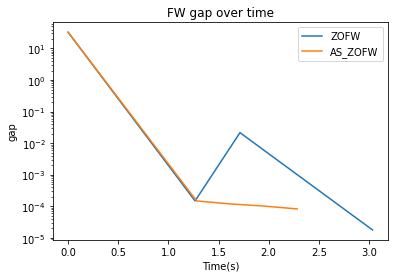

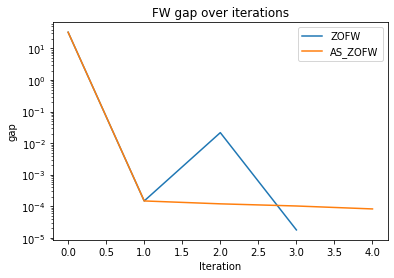

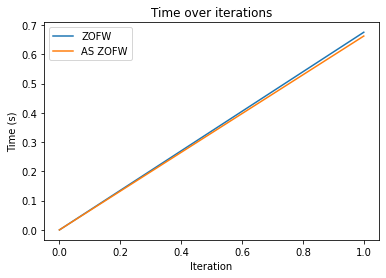

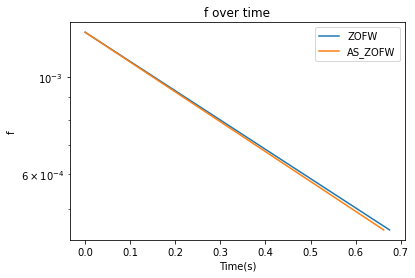

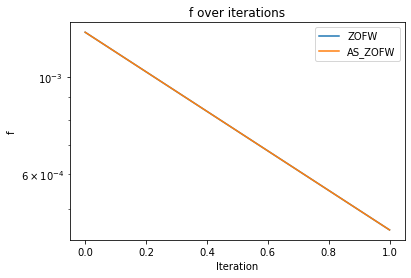

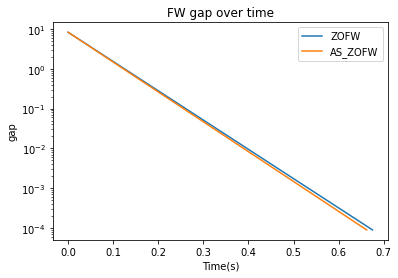

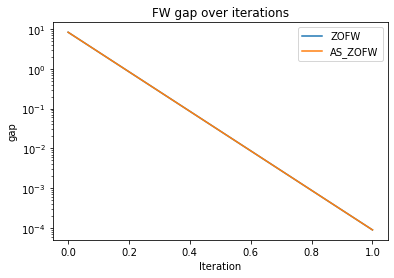

Dataset done


<ipython-input-199-89d48c87a02d>:7: RuntimeWarning: overflow encountered in reciprocal
  r=np.reciprocal(r)


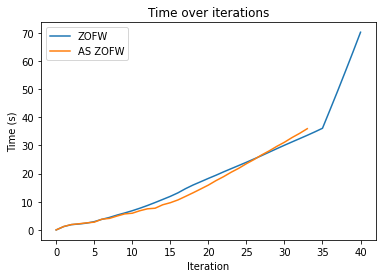

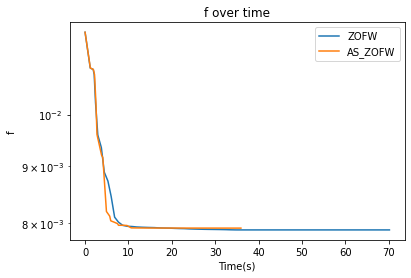

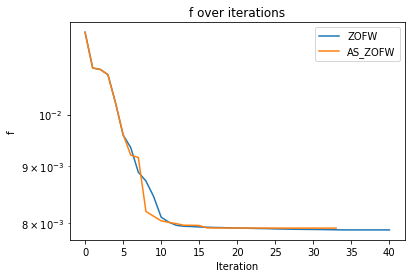

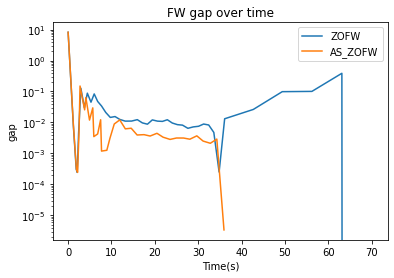

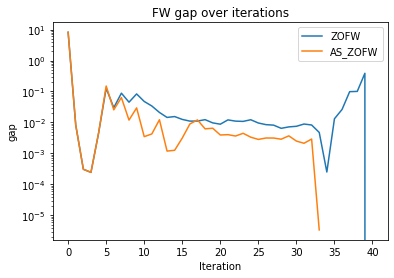

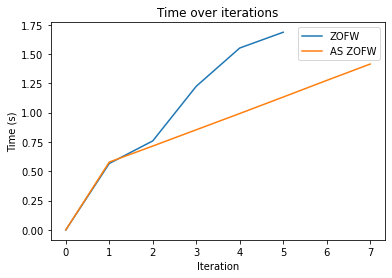

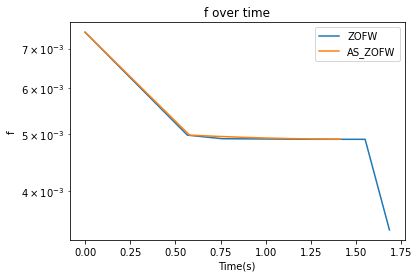

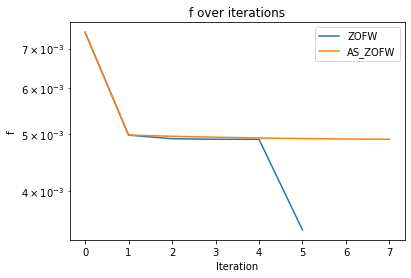

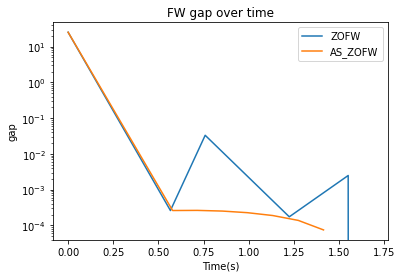

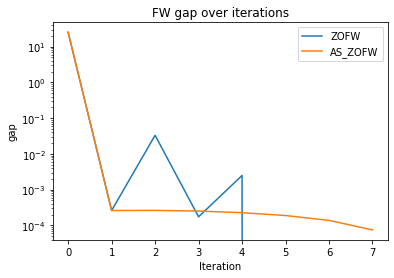

Dataset done


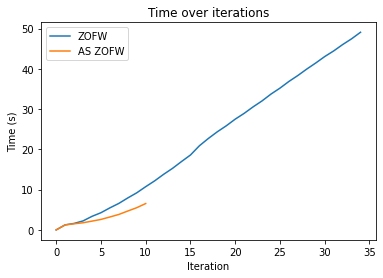

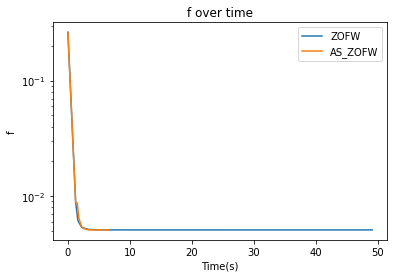

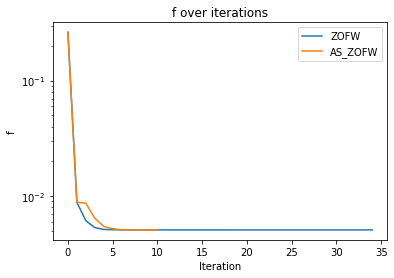

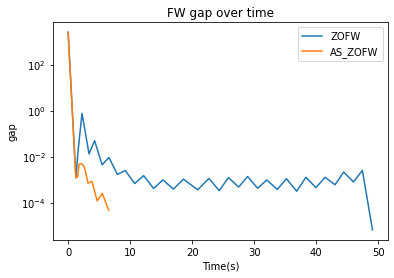

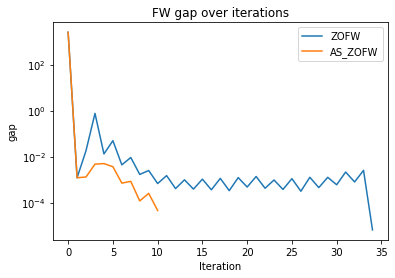

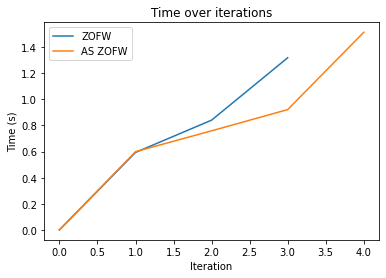

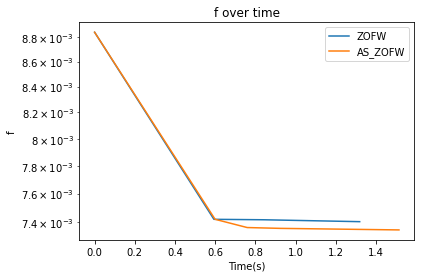

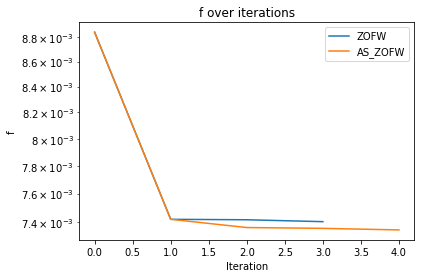

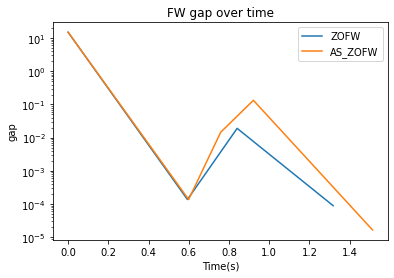

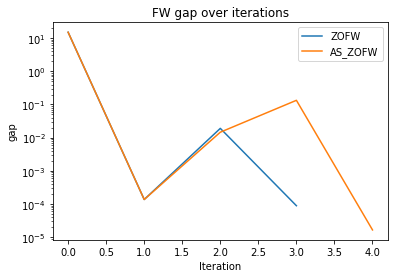

Dataset done


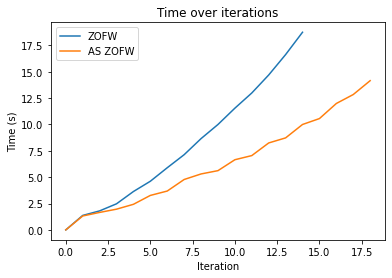

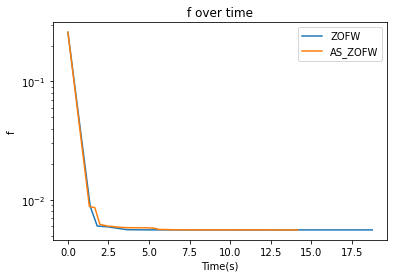

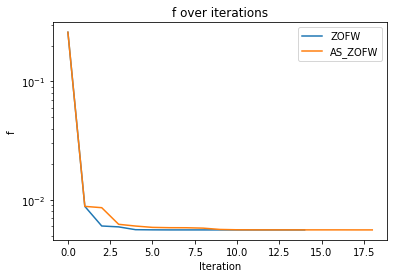

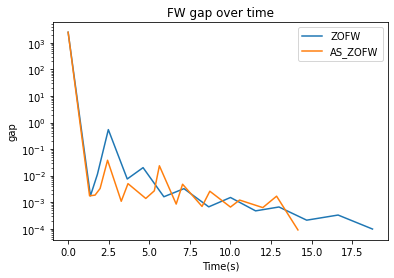

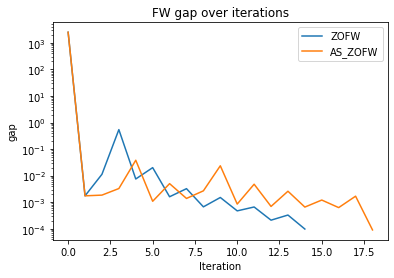

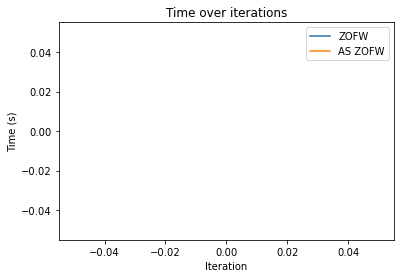

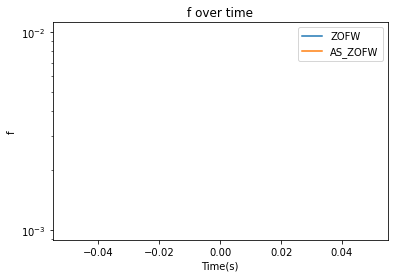

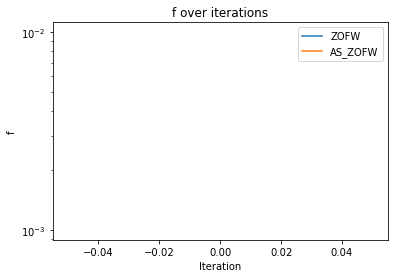

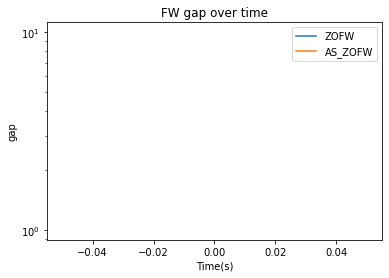

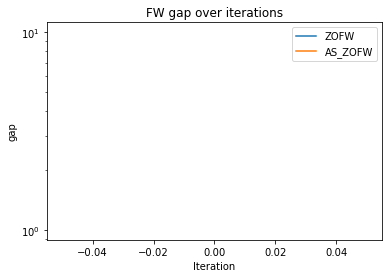

Dataset done


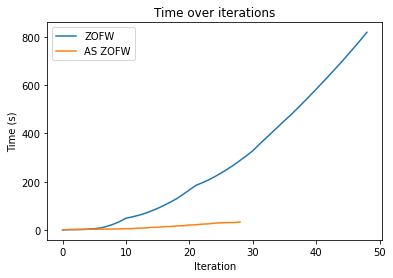

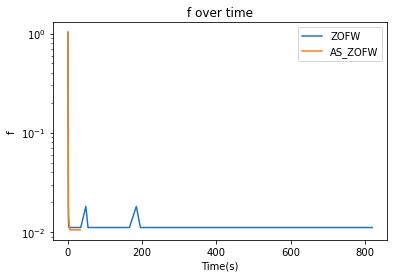

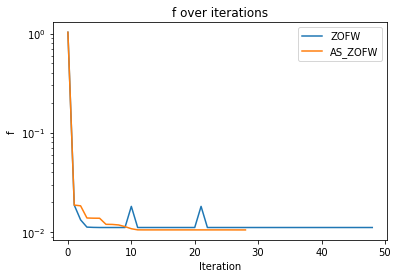

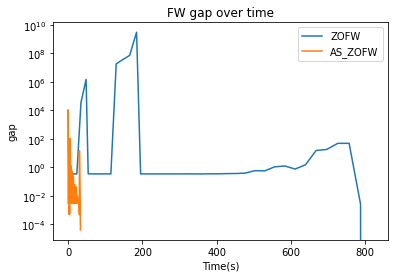

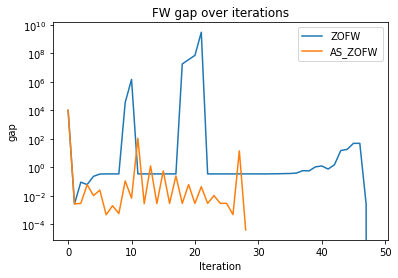

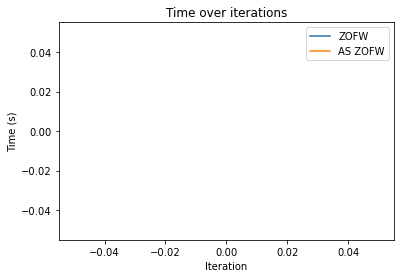

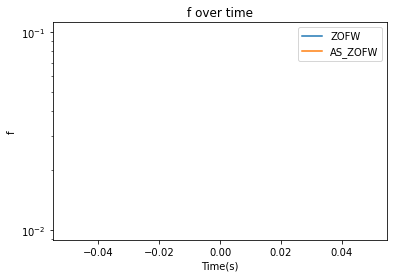

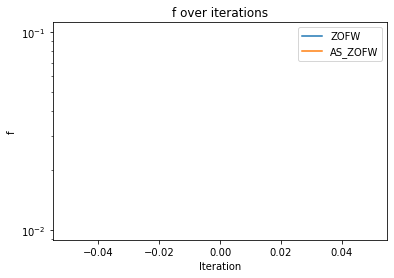

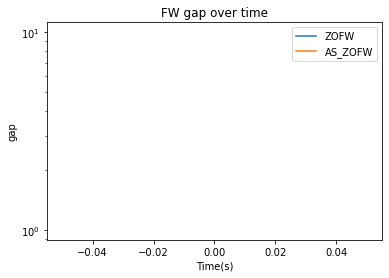

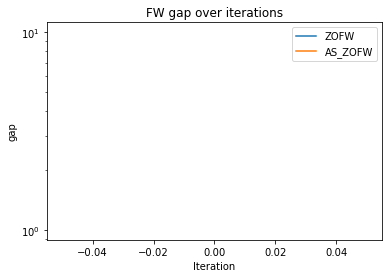

Dataset done


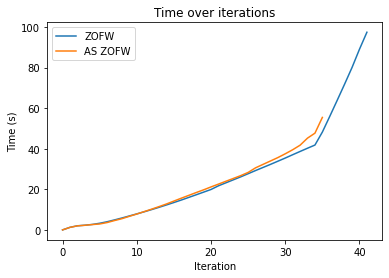

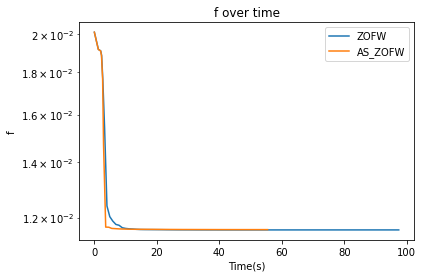

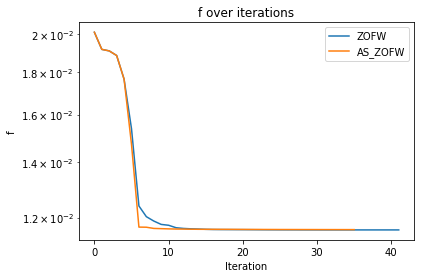

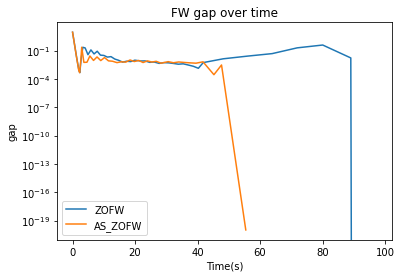

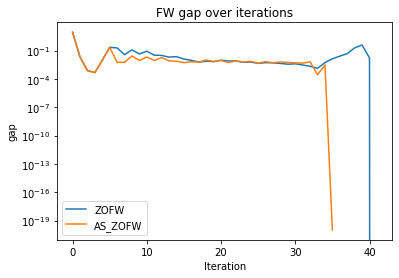

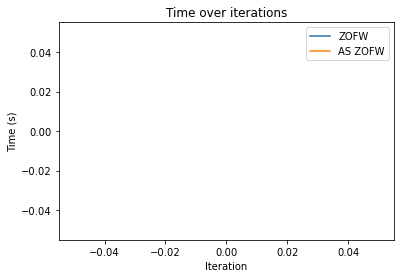

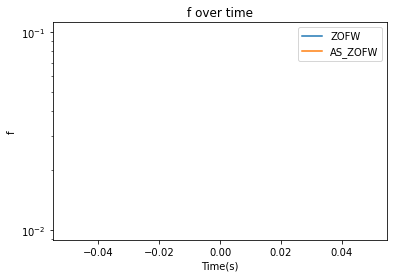

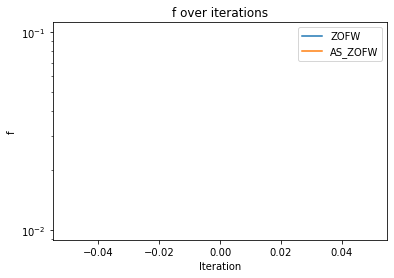

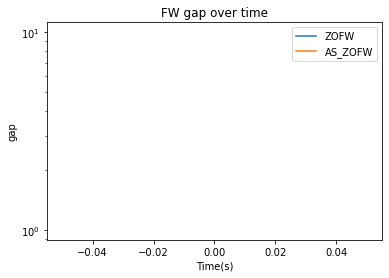

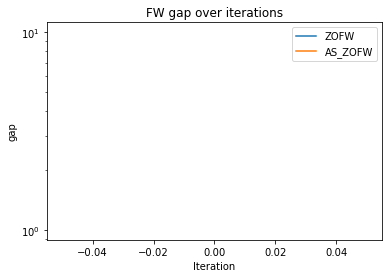

Dataset done


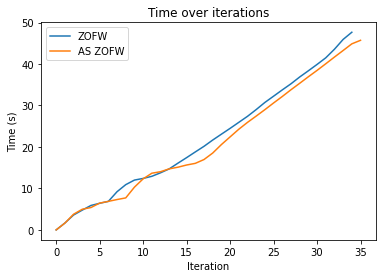

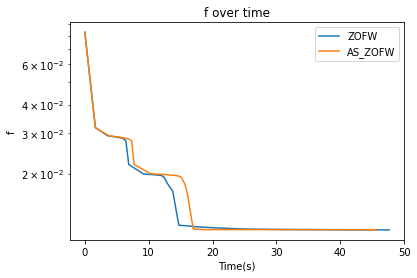

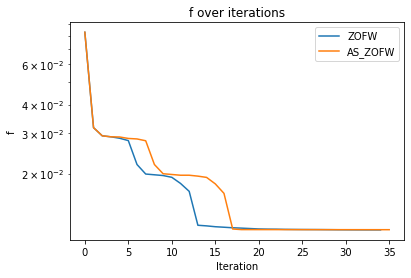

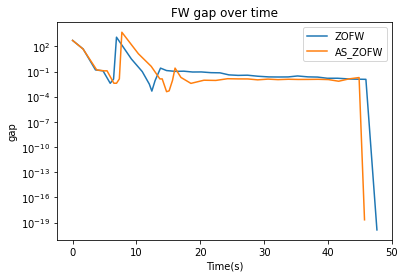

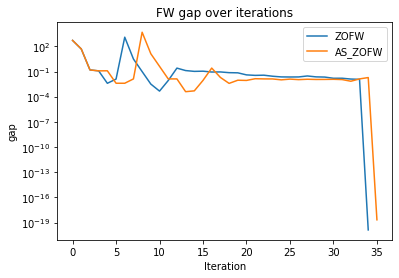

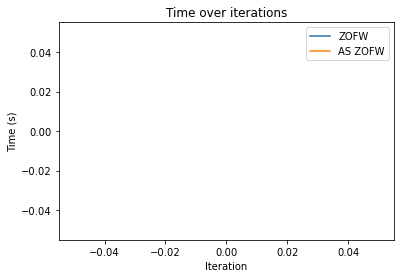

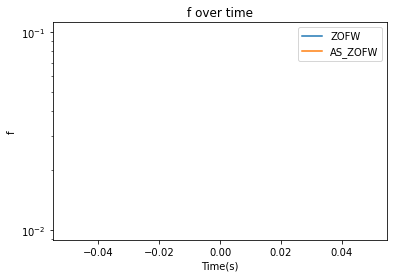

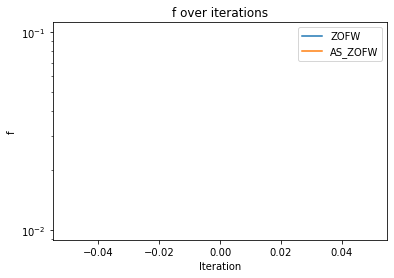

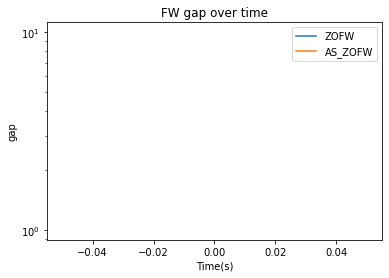

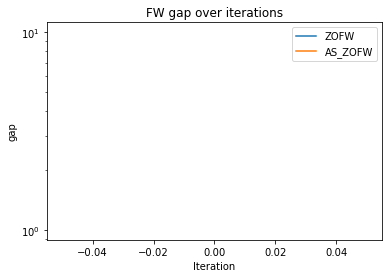

Dataset done


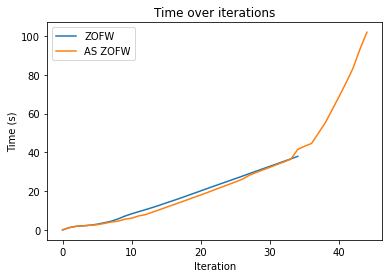

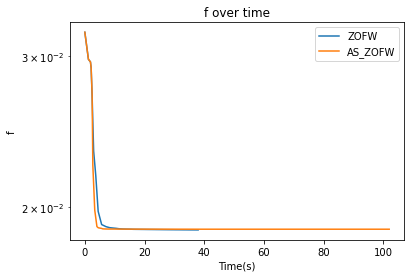

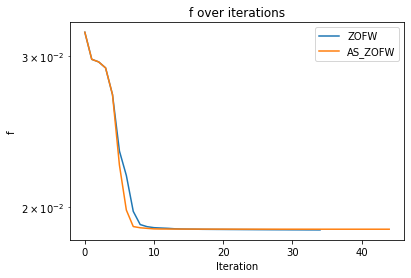

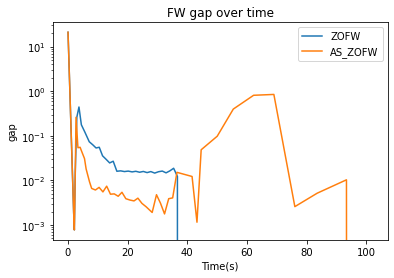

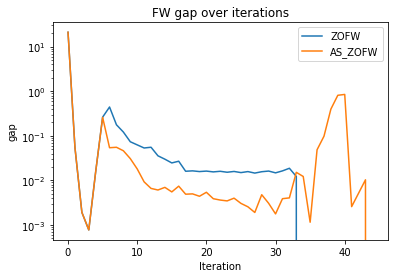

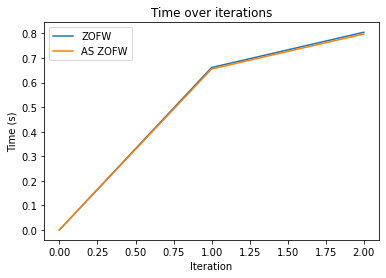

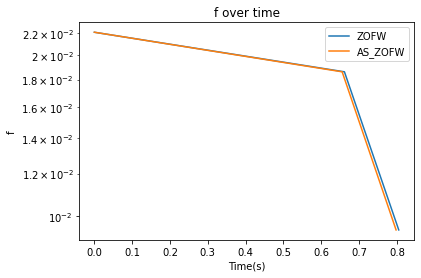

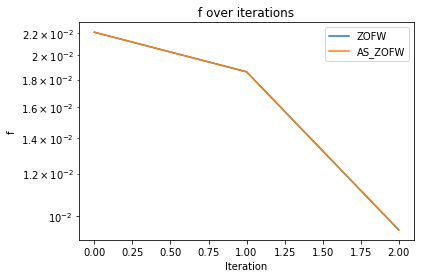

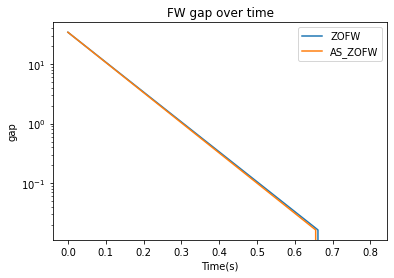

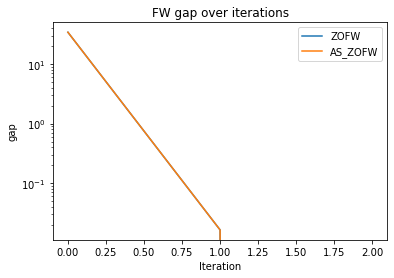

Dataset done


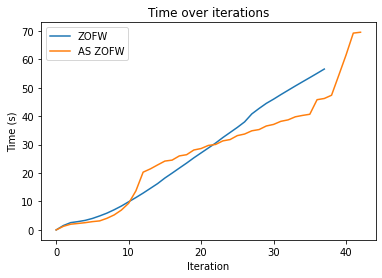

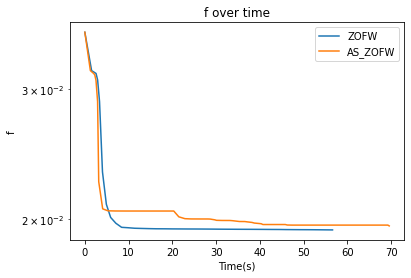

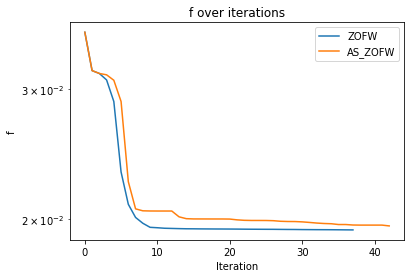

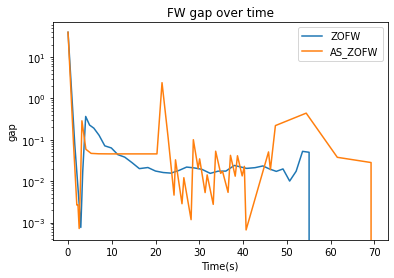

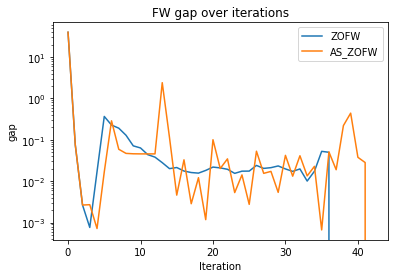

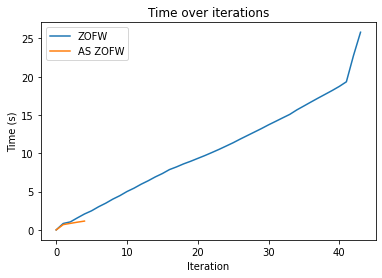

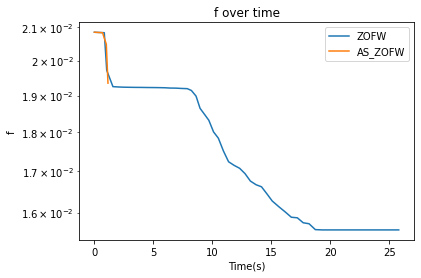

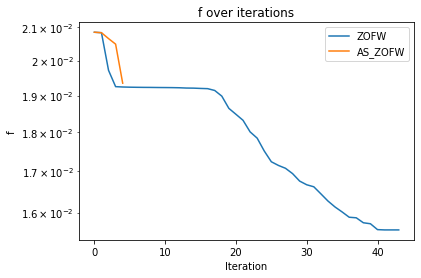

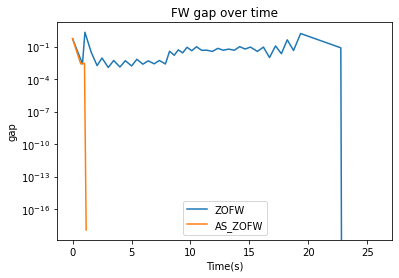

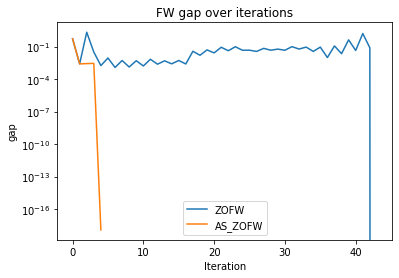

Dataset done


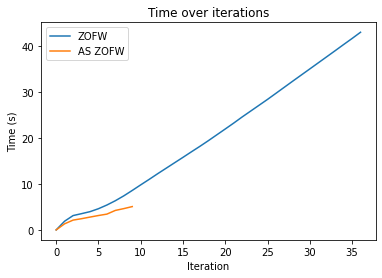

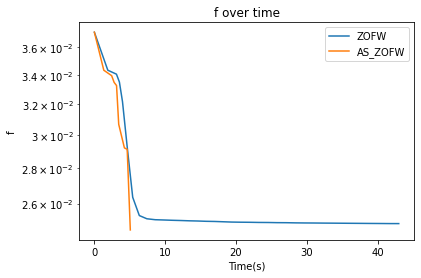

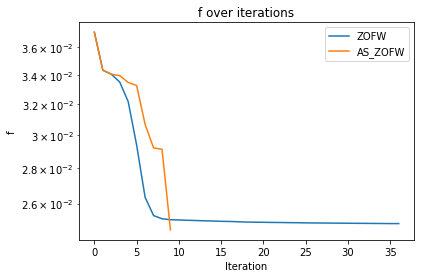

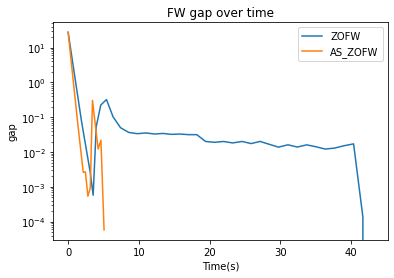

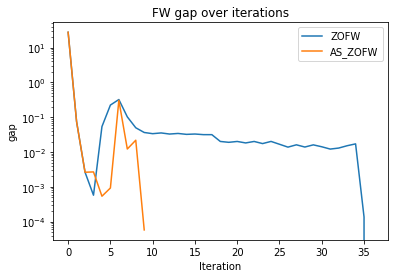

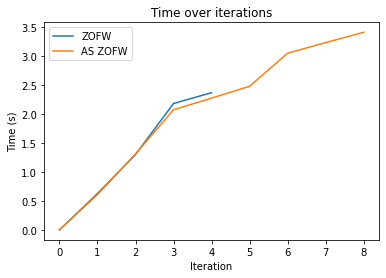

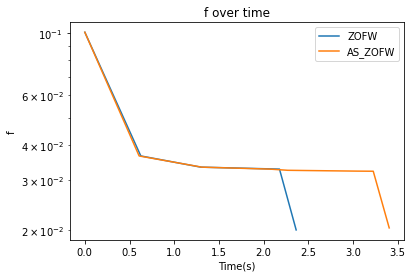

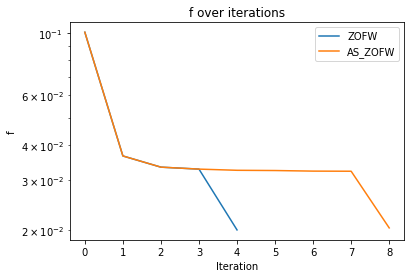

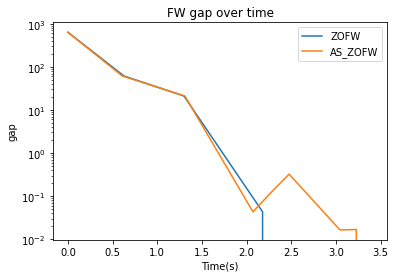

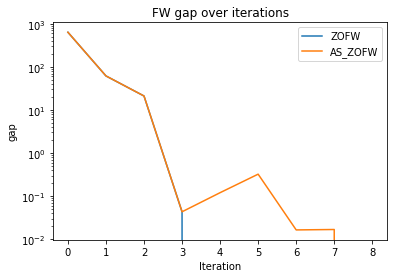

Dataset done


In [222]:
times_cora=[]
times_bbc=[]
for input_percent in [1,5,10,15]:
    for noise in [0,1,2]:
        times_cora.append(compare_FW(cora_datasets["{}_{}".format(input_percent,noise)]))
        times_bbc.append(compare_FW(BBC_datasets["{}_{}".format(input_percent,noise)]))
        print('Dataset done')



In [223]:
print(times_bbc)
print(times_cora)

[(0.0, 0.0), (1.0940721035003662, 1.246619701385498), (0.6751930713653564, 0.6622269153594971), (1.685450553894043, 1.4142611026763916), (1.3184757232666016, 1.5139517784118652), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.8048887252807617, 0.7978248596191406), (25.81033492088318, 1.152958631515503), (2.364717960357666, 3.405935287475586)]
[(1.973719835281372, 3.0737082958221436), (0.0, 0.0), (3.0348756313323975, 2.283963441848755), (70.19141721725464, 35.942912340164185), (49.084866762161255, 6.54642915725708), (18.74695086479187, 14.154157876968384), (819.7877221107483, 33.189220666885376), (97.39190697669983, 55.42524766921997), (47.66134285926819, 45.717331647872925), (37.96152400970459, 101.98195552825928), (56.5869619846344, 69.53276896476746), (42.99510908126831, 5.075427055358887)]
